# VGAEのデモンストレーション
- VGAEを活用
    - エンコーダー: GCN
    - デコーダー: InnerDecoder
- Coraネットワークを利用してネットワークを生成する


GPU PyTorchの動作確認

In [3]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.13.10 (main, Jan 10 2026, 11:37:40) [GCC 13.3.0]
PyTorch：2.8.0+cu129
CUDA：12.9
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [4]:
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import RandomLinkSplit

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None

# エッジをトレーニング、検証、テストセットに分割
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True, 
    add_negative_train_samples=True,
    split_labels=True
)
train_data, val_data, test_data = transform(data)

# データセットの情報を表示
print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")
print(f"TEST       node num: {test_data.x.size(0)}, edge num: {test_data.edge_index.size(1)}, node feature num: {test_data.num_node_features}")

TRAIN      node num: 2708, edge num: 8448, node feature num: 1433
VALIDATION node num: 2708, edge num: 8448, node feature num: 1433
TEST       node num: 2708, edge num: 9502, node feature num: 1433


Processing...
/app/.venv/lib/python3.13/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/app/.venv/lib/python3.13/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/app/.venv/lib/python3.13/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/app/.venv/lib/python3.13/site-packages/torch_geometric/io/planetoid.py:107: 

### データを可視化

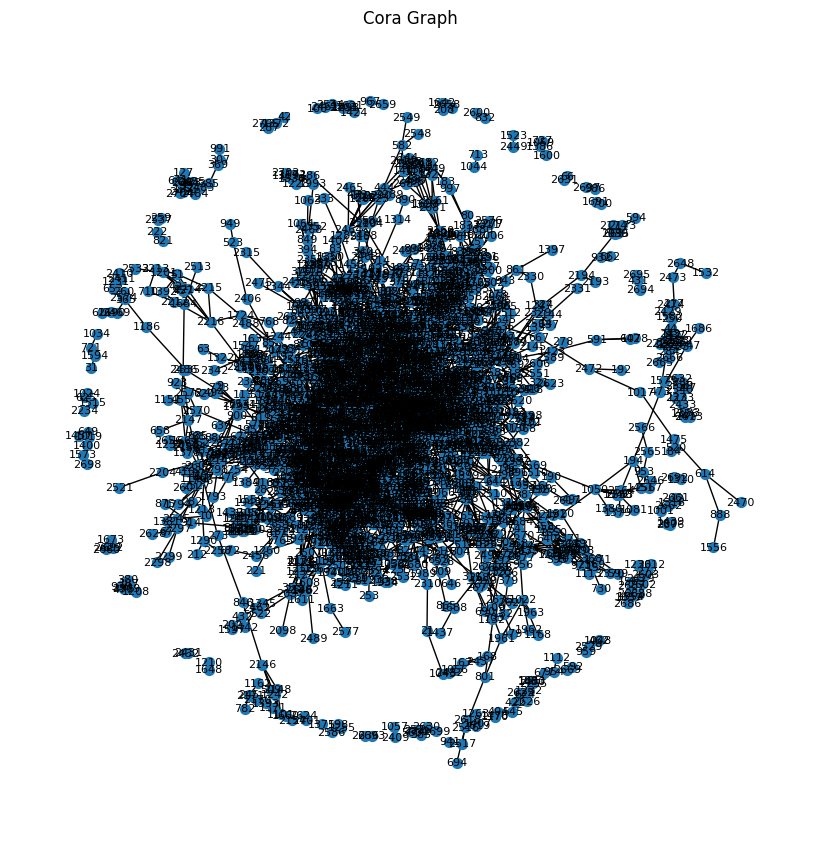

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(train_data.edge_index.t().tolist())

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## VGANを活用したグラフ生成

- Variational Graph Auto-encoder
- 既存のグラフを学習し新たなグラフを生成する

### VGAEモデルの定義

- Graph Encoder: Graph Convolution Network(GCN)
- Graph Decoder: InnerDecoder


In [6]:
from torch_geometric.nn import GCNConv, VGAE

# Encoderの定義
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [7]:
# モデルの設定
in_channels = train_data.x.size(-1) # 入力される特徴量の次元
out_channels = train_data.x.size(-1) # 出力される特徴量の次元
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels)) # エンコーダとデコーダーを合わせてモデルのインスタンス化
print(model)

# モデルとデータをデバイスに転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

入力特徴量の次元: 1433, 出力特徴量の次元: 1433
VGAE(
  (encoder): GraphEncoder(
    (conv1): GCNConv(1433, 2866)
    (conv_mu): GCNConv(2866, 1433)
    (conv_logstd): GCNConv(2866, 1433)
  )
  (decoder): InnerProductDecoder()
)


### モデルの学習
- パラメータの更新: Adam
- 目的関数
    - 再構成誤差: recon_loss
    - KLダイバージェンス: KL_loss

In [8]:
# 学習回数と最適化手法の設定
epoch_num = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# モデルの学習
model.train()
for epoch in range(1, epoch_num + 1):
    # 勾配の初期化
    optimizer.zero_grad()

    # モデルの出力
    z = model.encode(train_data.x, train_data.edge_index)

    # 損失の計算
    recon_loss = model.recon_loss(z, train_data.edge_index) # 再構成誤差
    kl_loss = (1 / train_data.num_nodes) * model.kl_loss() # KLダイバージェンス
    loss = recon_loss + kl_loss # 全体の損失

    # パラメータの更新
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 10, Loss: 34.6459846496582
Epoch 20, Loss: 20.6335506439209
Epoch 30, Loss: 16.9232234954834
Epoch 40, Loss: 14.638765335083008
Epoch 50, Loss: 12.501106262207031
Epoch 60, Loss: 10.588202476501465
Epoch 70, Loss: 9.010530471801758
Epoch 80, Loss: 8.33857536315918
Epoch 90, Loss: 7.844138145446777
Epoch 100, Loss: 7.889040946960449


### モデルの評価
- 2値分類としてネットワーク生成を評価する

**2値分類のネットワーク生成**
- ノードに対してエッジが接続される確率とエッジが接続されない確率の2値をを予測する
- 正負のエッジ
    - 正のエッジ: エッジが接続されるい確率
    - 負のエッジ: エッジが接続されない確率

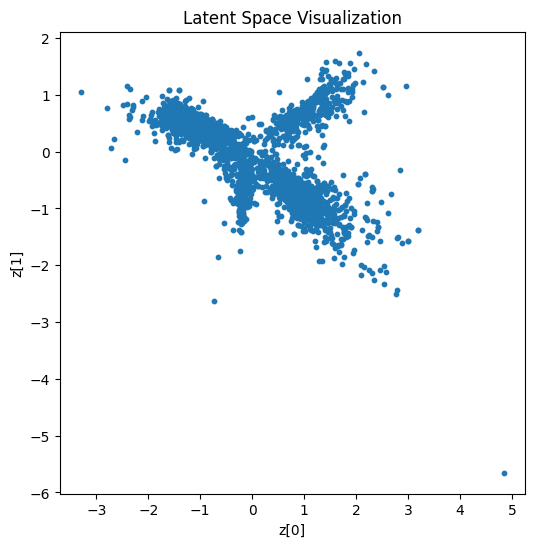

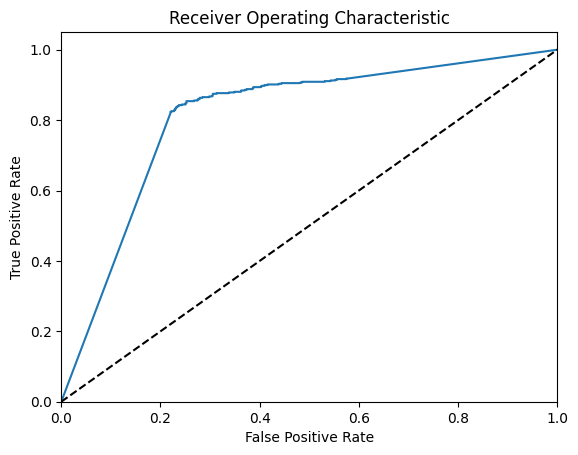

AUC Score: 0.8126
Accuracy: 0.8027
Precision: 0.7823
Recall: 0.8387
Optimal Threshold: 0.1995
Positive edge predictions (mean): 0.8360
Negative edge predictions (mean): 0.2325


In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
import numpy as np

# ネットワークの生成
model.eval()
with torch.no_grad():
    z = model.encode(val_data.x, val_data.edge_index)
    
    # 潜在ベクトルzの可視化
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
    plt.title("Latent Space Visualization")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # 潜在ベクトルzをデコードしてエッジの存在確率を予測
    x = model.decode(z, val_data.edge_index)

    # 正エッジを予測
    pos_edge_index = val_data.pos_edge_label_index
    pos_pred = model.decode(z, pos_edge_index).view(-1).cpu()

    # 負エッジを予測
    neg_edge_index = val_data.neg_edge_label_index
    neg_pred = model.decode(z, neg_edge_index).view(-1).cpu()

    # 予測スコアの結合
    preds = torch.cat([pos_pred, neg_pred], dim=0).cpu().numpy()

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0).cpu().numpy()

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax() 
    optimal_threshold = thresholds[optimal_idx]

    # 最適な閾値を用いてAccuracy/Precision/Recallの計算
    binary_preds = (preds >= optimal_threshold).astype(np.float32)
    accuracy = accuracy_score(labels, binary_preds)
    precision = precision_score(labels, binary_preds)
    recall = recall_score(labels, binary_preds)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # AUCスコアと分類精度を表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### ネットワークの生成
- テストデータを用いて検証
- 学習したモデルを用いてネットワークを生成する
- 生成したネットワークの可視化

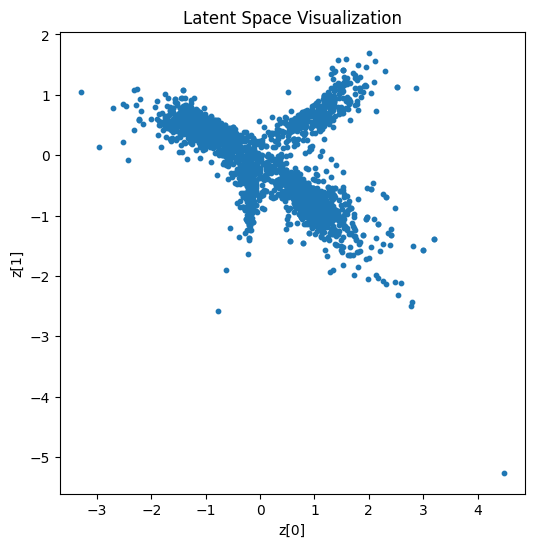

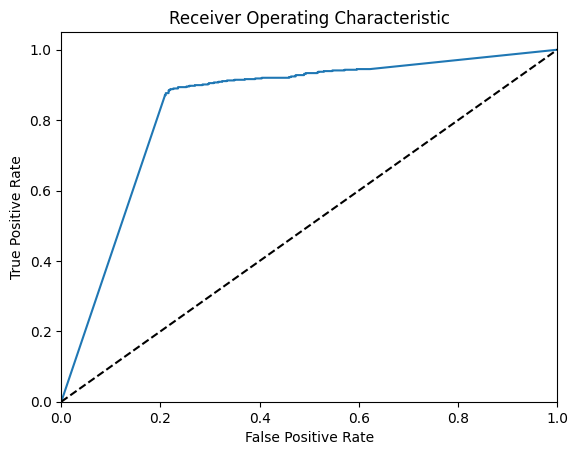

AUC Score: 0.8383
Accuracy: 0.8340
Precision: 0.8034
Recall: 0.8843
Optimal Threshold: 0.9261
Positive edge predictions (mean): 0.8843
Negative edge predictions (mean): 0.2169


In [10]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# ネットワークの生成
model.eval()
with torch.no_grad():
    # モデルから潜在ベクトルを出力
    z = model.encode(test_data.x, test_data.edge_index)

    # 潜在ベクトルzの可視化
    plt.figure(figsize=(6, 6))
    plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
    plt.title("Latent Space Visualization")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # 潜在ベクトルzをデコードして隣接行列を生成
    x = model.decode(z, test_data.edge_index)

    # 予測スコアの計算
    pos_edge_index = test_data.pos_edge_label_index
    pos_pred = model.decode(z, pos_edge_index).view(-1).cpu()
    neg_edge_index = test_data.neg_edge_label_index
    neg_pred = model.decode(z, neg_edge_index).view(-1).cpu()
    preds = torch.cat([pos_pred, neg_pred], dim=0).cpu().numpy()

    # 正解ラベルの作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels], dim=0).cpu().numpy()

    # AUCスコアの計算
    auc_score = roc_auc_score(labels, preds)

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, preds)

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax() 
    optimal_threshold = thresholds[optimal_idx]

    # 最適な閾値を用いてAccuracy/Precision/Recallの計算
    binary_preds = (preds >= optimal_threshold).astype(np.float32)
    accuracy = accuracy_score(labels, binary_preds)
    precision = precision_score(labels, binary_preds)
    recall = recall_score(labels, binary_preds)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # 潜在ベクトルzをデコードして隣接行列を生成
    prob = torch.sigmoid(z @ z.t())  # xとzの内積を計算して接続確率を算出
    adj_matrix = (prob > optimal_threshold).nonzero(as_tuple=False).t() # 二値化して隣接行列を生成
    adj_matrix = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:test_data.num_edges]] # エッジをサンプリング

    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

**生成したネットワークの可視化**

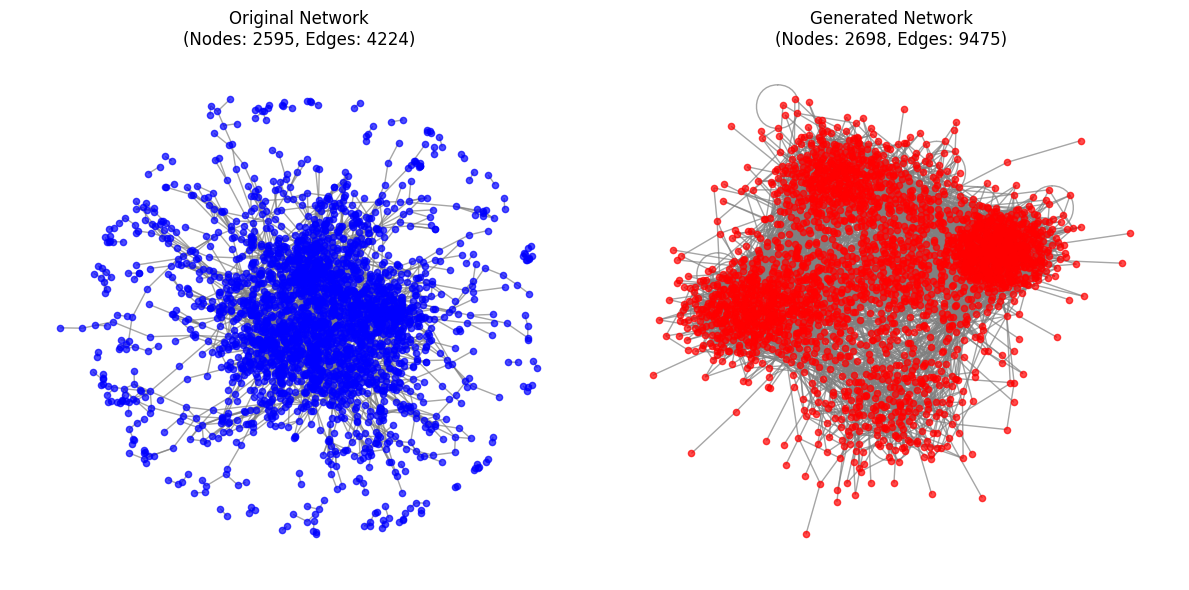

=== Network Statistics Comparison ===
Original Network  - Nodes: 2595, Edges: 4224
Generated Network - Nodes: 2698, Edges: 9475
Original avg degree: 3.26
Generated avg degree: 7.02


In [11]:
G_generated = nx.Graph()

# adj_matrixから生成されたエッジを追加
edges = adj_matrix.t().cpu().numpy()
G_generated.add_edges_from(edges)

# 生成されたネットワークの可視化
plt.figure(figsize=(12, 6))

# 元のネットワークと生成されたネットワークを比較表示
plt.subplot(1, 2, 1)
pos_original = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos_original, with_labels=False, node_size=20, node_color='blue', edge_color='gray', alpha=0.7)
plt.title(f"Original Network\n(Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()})")

plt.subplot(1, 2, 2)
pos_generated = nx.spring_layout(G_generated, k=0.5, iterations=50)
nx.draw(G_generated, pos_generated, with_labels=False, node_size=20, node_color='red', edge_color='gray', alpha=0.7)
plt.title(f"Generated Network\n(Nodes: {G_generated.number_of_nodes()}, Edges: {G_generated.number_of_edges()})")

plt.tight_layout()
plt.show()

# ネットワーク統計の比較
print("=== Network Statistics Comparison ===")
print(f"Original Network  - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Generated Network - Nodes: {G_generated.number_of_nodes()}, Edges: {G_generated.number_of_edges()}")

if G.number_of_nodes() > 0 and G_generated.number_of_nodes() > 0:
    print(f"Original avg degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
    print(f"Generated avg degree: {2 * G_generated.number_of_edges() / G_generated.number_of_nodes():.2f}")